<img src="https://www.collinsdictionary.com/images/full/xray_560923156_1000.jpg" width="620" height="360" align="center"/>

<br>
<h1 style = "font-size:30px; font-weight : bold; color : blue; text-align: center; border-radius: 10px 15px;">Chest X-Ray (Pneumonia): Image Classification w/Convolutional Neural Networks and Transfer Learning</h1>
<br>

---

# Overview

The goal of this notebook is to use Convolutional Neural Networks on Chest X-Ray images to determine which samples are from patients with Pneumonia. In this dataset (version 3), there is one folder representing the train set and another one for the test set. The train folder is later split in the notebook into train/validation sets.

I use three different approaches for image classification: 1) A simple CNN, 2) Transfer Learning, using a pretrained model with frozen layers as the base for feature extraction and 3) Fine Tuning, unfreezing the last layers of the pretrained model.

Note: I’m using the third version of the Chest X-Ray dataset [(link)](https://www.kaggle.com/tolgadincer/labeled-chest-xray-images)

# <a id='0'>Content</a>
​
- <a href='#1'>Dataset Information</a>  
- <a href='#2'>Importing Packages and Dataset</a>  
- <a href='#3'>Exploring the Data</a>  
- <a href='#4'>Preparing the Data</a>
- <a href='#5'>Custom Model</a>
- <a href='#6'>Transfer Learning</a>
- <a href='#7'>Fine Tuning</a>
- <a href='#8'>Performance Metrics</a>
- <a href='#9'>References</a>

# <a id="1">Dataset Information</a> 

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# <a id="2">Importing Packages and Dataset</a> 

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_curve, auc


In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
#main_path = "../input/chest-xray-pneumonia/chest_xray/"
main_path = r"C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5227  Pneumonia   
5228  Pneumonia   
5229  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                                                                  image  
0       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-1003233-0001.jpeg  
1       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-1012843-0001.jpeg  
2       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-1014768-0001.jpeg  
3       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-1023731-0001.jpeg  
4       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-1029510-0001.jpeg  
...                                                                                                 ...  
5227  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-9934736-0003.jpeg  
5228  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-9947411-0002.jpeg  
5229  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-9962961-0002.jpeg  
5230  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-9963654-0001.jpeg  
5231  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-9975428-0002.jpeg  

[5232 rows x 2 columns]

In [6]:
df_test

class  \
0       Normal   
1       Normal   
2       Normal   
3       Normal   
4       Normal   
..         ...   
619  Pneumonia   
620  Pneumonia   
621  Pneumonia   
622  Pneumonia   
623  Pneumonia   

                                                                                                image  
0      C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/NORMAL\NORMAL-1049278-0001.jpeg  
1      C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/NORMAL\NORMAL-1110860-0001.jpeg  
2        C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/NORMAL\NORMAL-11419-0001.jpeg  
3       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/NORMAL\NORMAL-115218-0001.jpeg  
4      C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/NORMAL\NORMAL-1160949-0001.jpeg  
..                                                                                                ...  
619  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/PNEUMONIA\VIRUS-9584831-0001.jpeg  
620  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/PNEUMONIA\VIRUS-9671740-0001.jpeg  
621  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/PNEUMONIA\VIRUS-9783315-0001.jpeg  
622  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/PNEUMONIA\VIRUS-9890836-0001.jpeg  
623  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\test/PNEUMONIA\VIRUS-9968655-0001.jpeg  

[624 rows x 2 columns]

# <a id="3">Exploring the Data</a> 

Let's check the target distribution on each set

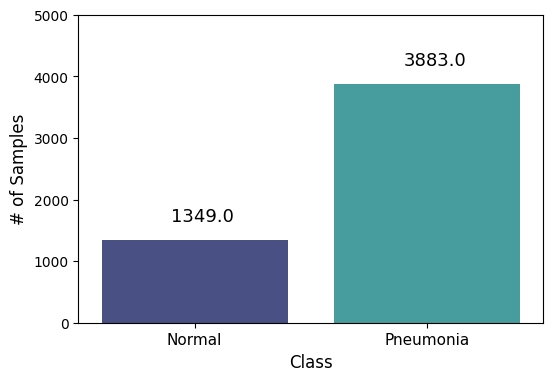

In [7]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

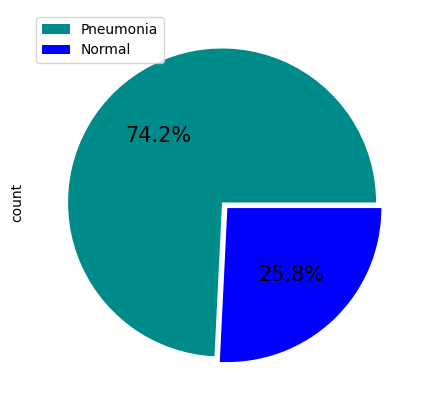

In [8]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

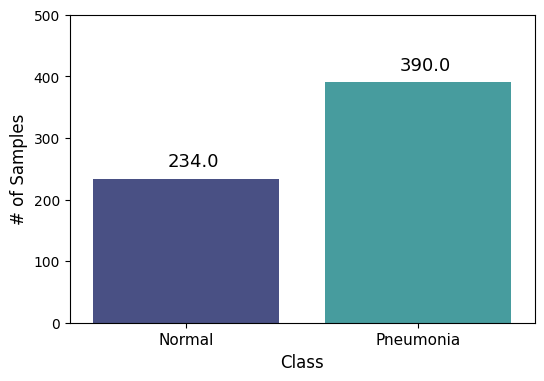

In [9]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

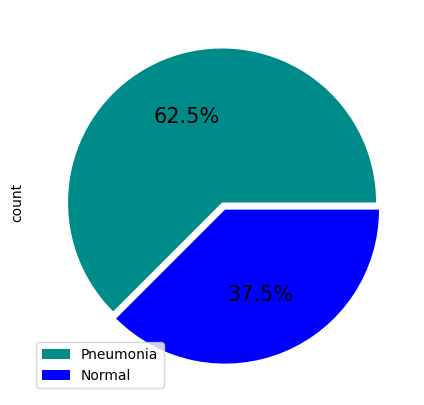

In [10]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

Train Set - Normal


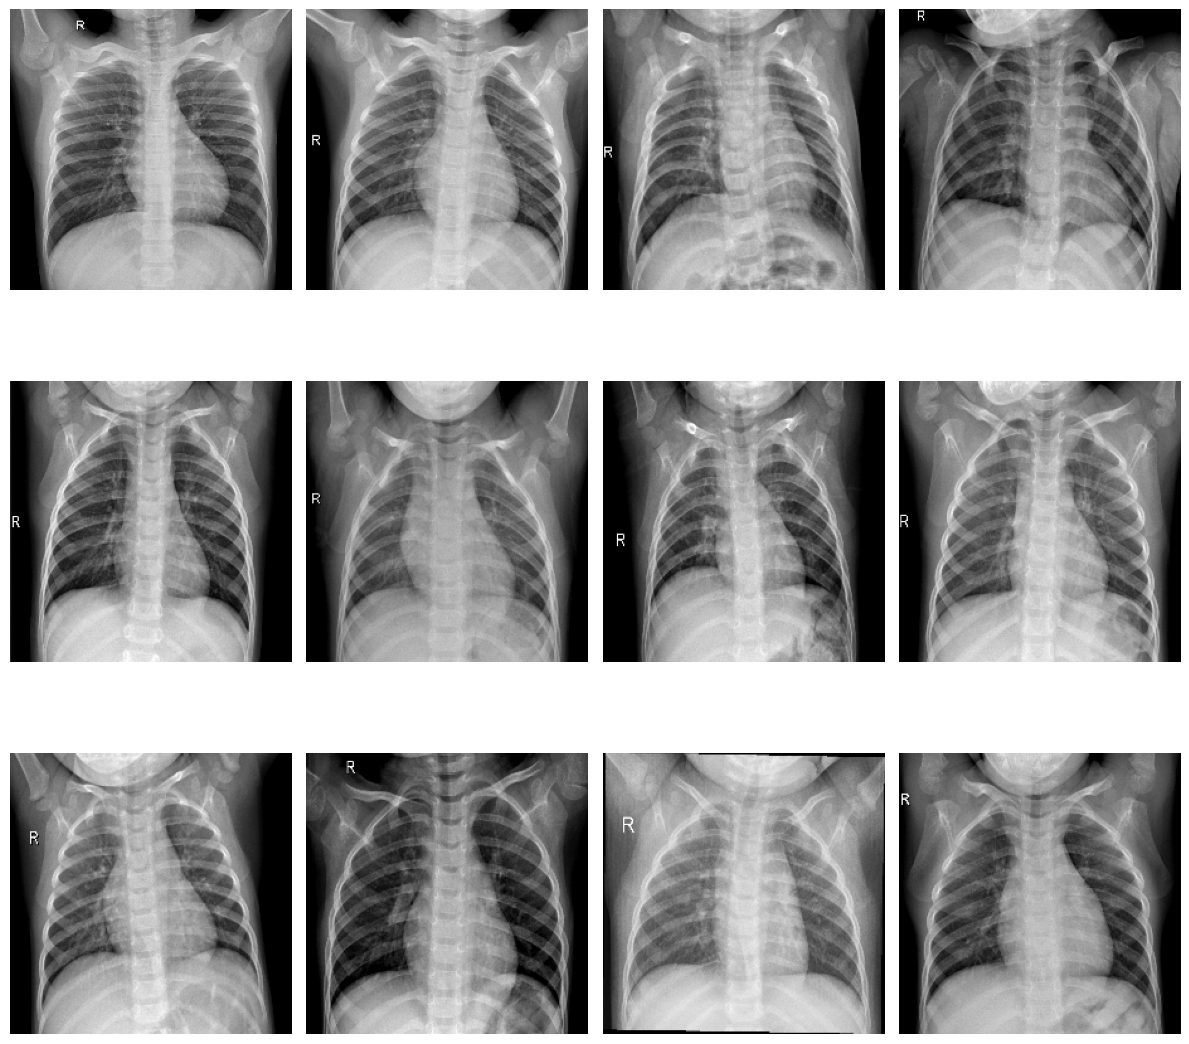

In [11]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


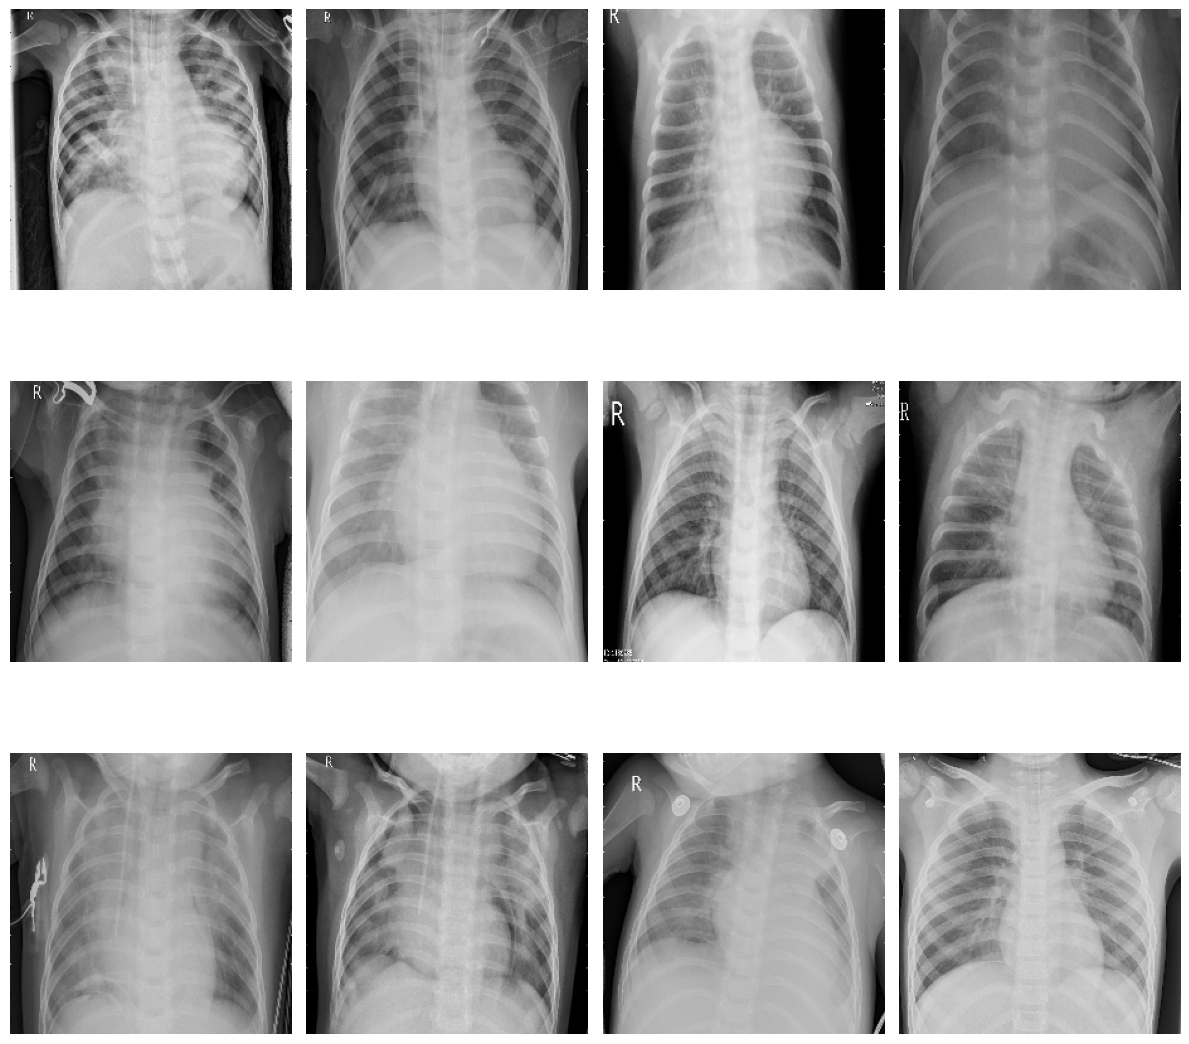

In [12]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


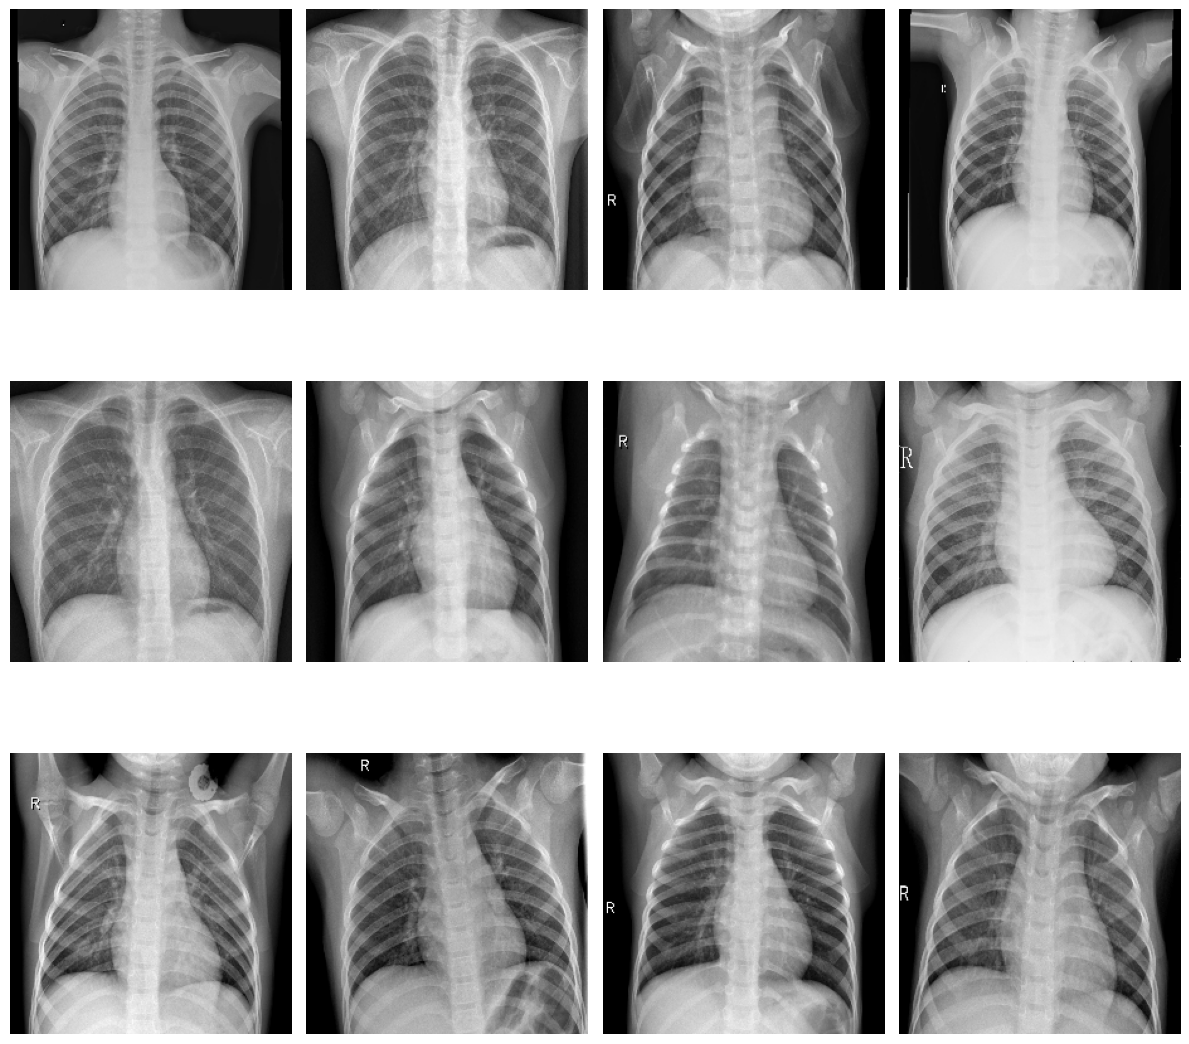

In [13]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


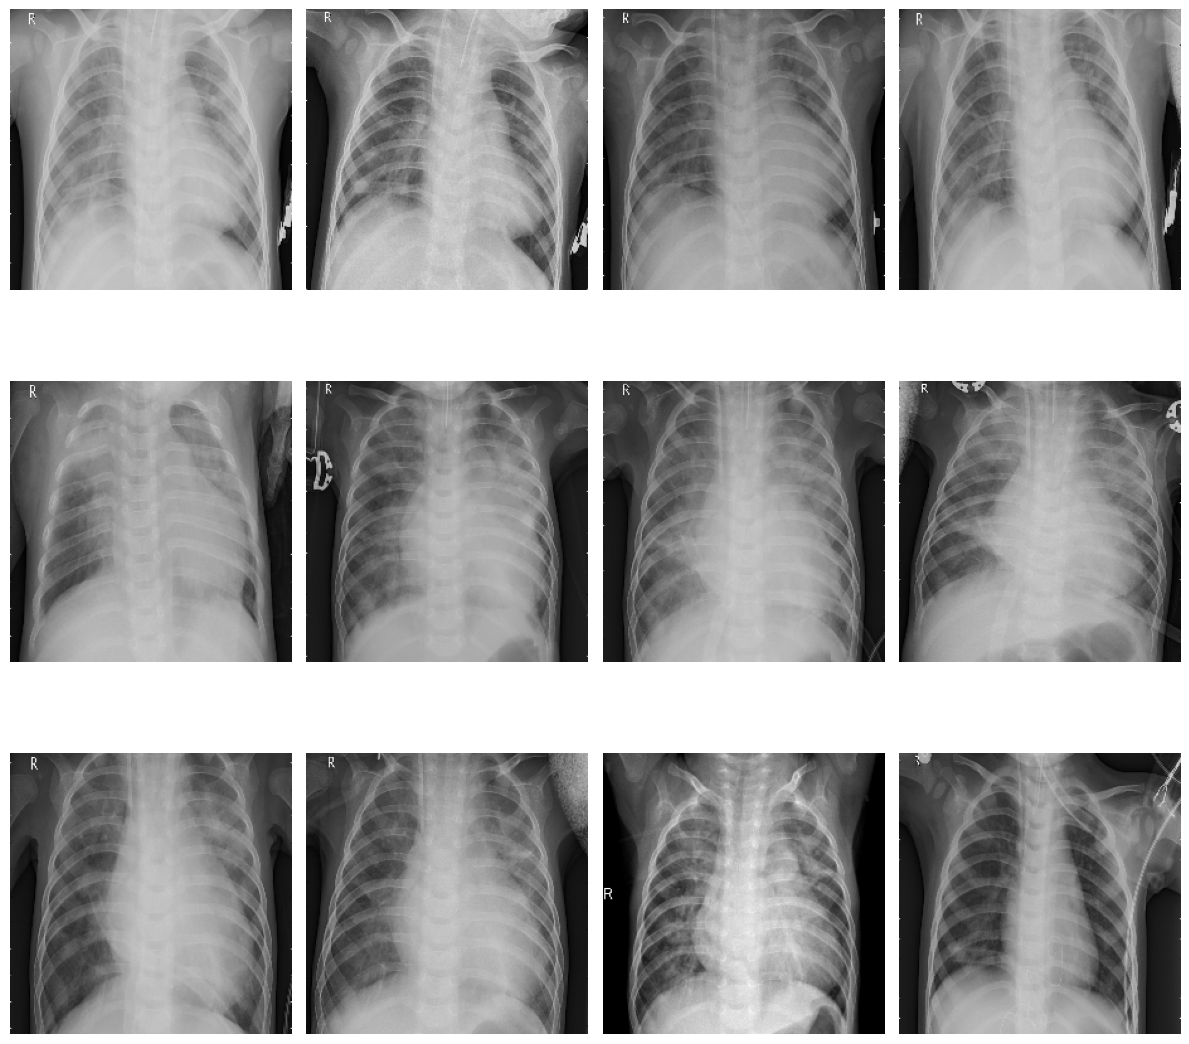

In [14]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# <a id="4">Preparing the Data</a> 

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [15]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [16]:
val_df

class  \
2945  Pneumonia   
4878  Pneumonia   
3177  Pneumonia   
972      Normal   
3059  Pneumonia   
...         ...   
253      Normal   
4315  Pneumonia   
687      Normal   
3417  Pneumonia   
3745  Pneumonia   

                                                                                                    image  
2945  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-654117-0001.jpeg  
4878    C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-7603659-0001.jpeg  
3177  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-7512869-0002....  
972       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-7436212-0002.jpeg  
3059  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-7022864-0004....  
...                                                                                                   ...  
253       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-2699389-0002.jpeg  
4315    C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-3896078-0002.jpeg  
687        C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-566227-0001.jpeg  
3417  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-8313249-0001....  
3745  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-9424776-0005....  

[1047 rows x 2 columns]

In [17]:
train_df

class  \
3566  Pneumonia   
2866  Pneumonia   
2681  Pneumonia   
1199     Normal   
4619  Pneumonia   
...         ...   
3476  Pneumonia   
678      Normal   
1560  Pneumonia   
2769  Pneumonia   
4881  Pneumonia   

                                                                                                    image  
3566  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-8718799-0001....  
2866  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-6295192-0003....  
2681  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-5615122-0001....  
1199      C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-9031828-0001.jpeg  
4619    C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-5822550-0001.jpeg  
...                                                                                                   ...  
3476  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-8467199-0001....  
678       C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/NORMAL\NORMAL-5634312-0001.jpeg  
1560  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-1797366-0001....  
2769  C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\BACTERIA-5965088-0001....  
4881    C:\Users\Dell\OneDrive\Desktop\computer_vision\chest_xray\train/PNEUMONIA\VIRUS-7611162-0001.jpeg  

[4185 rows x 2 columns]

Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [18]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Custom CNN</a>

In [19]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

Let’s define our first model ‘from scratch’ and see how it performs.

In [20]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [21]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0   

In [22]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 3,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/3


130/130 [==============================] - 116s 875ms/step - loss: 0.4762 - binary_accuracy: 0.7873 - val_loss: 0.9859 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/3
130/130 [==============================] - 113s 868ms/step - loss: 0.3063 - binary_accuracy: 0.8671 - val_loss: 1.9545 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/3
131/130 [==============================] - ETA: 0s - loss: 0.2577 - binary_accuracy: 0.8977
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 113s 865ms/step - loss: 0.2577 - binary_accuracy: 0.8977 - val_loss: 1.7573 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05


In [23]:
# Assuming ds_test is the data generator for the test set
# If you don't have a data generator for the test set, you can create one similar to ds_train and ds_val

# Make predictions on the test set
predictions = model.predict(ds_test, steps=len(ds_test), verbose=1)

# Assuming predictions are probabilities, you can convert them to binary predictions (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Display the first few predictions
print("Predictions:", binary_predictions[:5])


624/624 [==============================] - 9s 14ms/step
Predictions: [[1]
 [1]
 [1]
 [1]
 [1]]


In [24]:
num_features = ds_test.next()[0].shape[1]
print("Number of features:", num_features)


Number of features: 224


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 166ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:24, 40.97it/s]

1/1 [==============================] - 0s 61ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:17, 54.54it/s]

1/1 [==============================] - 0s 68ms/step


  3%|██▍                                                                             | 30/1000 [00:00<00:16, 59.97it/s]

1/1 [==============================] - 0s 60ms/step


  4%|███▏                                                                            | 40/1000 [00:00<00:14, 64.44it/s]

1/1 [==============================] - 0s 59ms/step


  5%|████                                                                            | 50/1000 [00:00<00:14, 66.73it/s]

1/1 [==============================] - 0s 59ms/step


  6%|████▊                                                                           | 60/1000 [00:00<00:13, 68.67it/s]

1/1 [==============================] - 0s 59ms/step


  7%|█████▌                                                                          | 70/1000 [00:01<00:13, 70.50it/s]

1/1 [==============================] - 0s 62ms/step


  8%|██████▍                                                                         | 80/1000 [00:01<00:13, 70.67it/s]

1/1 [==============================] - 0s 75ms/step


  9%|███████▏                                                                        | 90/1000 [00:01<00:13, 68.34it/s]

1/1 [==============================] - 0s 59ms/step


 10%|███████▉                                                                       | 100/1000 [00:01<00:12, 69.31it/s]

1/1 [==============================] - 0s 63ms/step


 11%|████████▋                                                                      | 110/1000 [00:01<00:12, 69.64it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▍                                                                     | 120/1000 [00:01<00:12, 68.09it/s]

1/1 [==============================] - 0s 57ms/step


 13%|██████████▎                                                                    | 130/1000 [00:01<00:12, 69.06it/s]

1/1 [==============================] - 0s 58ms/step


 14%|███████████                                                                    | 140/1000 [00:02<00:12, 70.92it/s]

1/1 [==============================] - 0s 57ms/step


 15%|███████████▊                                                                   | 150/1000 [00:02<00:11, 72.49it/s]

1/1 [==============================] - 0s 76ms/step


 16%|████████████▋                                                                  | 160/1000 [00:02<00:11, 70.66it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:02<00:11, 70.58it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▏                                                                | 180/1000 [00:02<00:12, 67.92it/s]

1/1 [==============================] - 0s 57ms/step


 19%|███████████████                                                                | 190/1000 [00:02<00:11, 69.96it/s]

1/1 [==============================] - 0s 58ms/step


 20%|███████████████▊                                                               | 200/1000 [00:02<00:11, 71.67it/s]

1/1 [==============================] - 0s 70ms/step


 21%|████████████████▌                                                              | 210/1000 [00:03<00:11, 70.83it/s]

1/1 [==============================] - 0s 60ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:03<00:10, 71.42it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:03<00:10, 71.39it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:03<00:10, 70.80it/s]

1/1 [==============================] - 0s 57ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:03<00:10, 72.26it/s]

1/1 [==============================] - 0s 68ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:03<00:10, 70.94it/s]

1/1 [==============================] - 0s 59ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:03<00:10, 70.98it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██████████████████████                                                         | 280/1000 [00:04<00:10, 71.09it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:04<00:10, 70.63it/s]

1/1 [==============================] - 0s 65ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:04<00:09, 70.00it/s]

1/1 [==============================] - 0s 65ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:04<00:09, 70.02it/s]

1/1 [==============================] - 0s 58ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:04<00:09, 71.09it/s]

1/1 [==============================] - 0s 59ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:04<00:09, 71.43it/s]

1/1 [==============================] - 0s 59ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:04<00:09, 71.46it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:05<00:08, 72.81it/s]

1/1 [==============================] - 0s 58ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:05<00:09, 70.96it/s]

1/1 [==============================] - 0s 57ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:05<00:08, 72.33it/s]

1/1 [==============================] - 0s 56ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:05<00:08, 73.69it/s]

1/1 [==============================] - 0s 59ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:05<00:08, 73.62it/s]

1/1 [==============================] - 0s 67ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:05<00:08, 72.20it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:05<00:08, 73.69it/s]

1/1 [==============================] - 0s 65ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:06<00:07, 72.88it/s]

1/1 [==============================] - 0s 64ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:06<00:07, 72.15it/s]

1/1 [==============================] - 0s 71ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:06<00:07, 70.56it/s]

1/1 [==============================] - 0s 60ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:06<00:07, 71.44it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:06<00:07, 71.34it/s]

1/1 [==============================] - 0s 60ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:06<00:07, 70.46it/s]

1/1 [==============================] - 0s 57ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:06<00:07, 72.08it/s]

1/1 [==============================] - 0s 58ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:06<00:07, 72.82it/s]

1/1 [==============================] - 0s 59ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:07<00:06, 72.52it/s]

1/1 [==============================] - 0s 60ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:07<00:06, 72.60it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:07<00:06, 73.72it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:07<00:06, 73.50it/s]

1/1 [==============================] - 0s 78ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:07<00:06, 70.73it/s]

1/1 [==============================] - 0s 57ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:07<00:06, 72.23it/s]

1/1 [==============================] - 0s 57ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:07<00:05, 73.41it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:08<00:05, 72.54it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:08<00:05, 72.59it/s]

1/1 [==============================] - 0s 63ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:08<00:05, 70.63it/s]

1/1 [==============================] - 0s 66ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:08<00:05, 70.58it/s]

1/1 [==============================] - 0s 59ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:08<00:05, 70.33it/s]

1/1 [==============================] - 0s 70ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:08<00:05, 68.77it/s]

1/1 [==============================] - 0s 77ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:08<00:05, 67.36it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:09<00:05, 69.32it/s]

1/1 [==============================] - 0s 57ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:09<00:04, 70.12it/s]

1/1 [==============================] - 0s 61ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:09<00:04, 70.79it/s]

1/1 [==============================] - 0s 73ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:09<00:04, 68.77it/s]

1/1 [==============================] - 0s 58ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:09<00:04, 70.91it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:09<00:04, 70.61it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:09<00:04, 70.24it/s]

1/1 [==============================] - 0s 58ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:10<00:04, 71.08it/s]

1/1 [==============================] - 0s 64ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:10<00:03, 70.42it/s]

1/1 [==============================] - 0s 58ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:10<00:03, 71.52it/s]

1/1 [==============================] - 0s 59ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:10<00:03, 71.86it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:10<00:03, 71.87it/s]

1/1 [==============================] - 0s 60ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:10<00:03, 71.48it/s]

1/1 [==============================] - 0s 70ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:10<00:03, 69.79it/s]

1/1 [==============================] - 0s 59ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:11<00:03, 70.65it/s]

1/1 [==============================] - 0s 64ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:11<00:02, 70.11it/s]

1/1 [==============================] - 0s 57ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:11<00:02, 71.94it/s]

1/1 [==============================] - 0s 58ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:11<00:02, 71.69it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:11<00:02, 70.27it/s]

1/1 [==============================] - 0s 59ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:11<00:02, 70.66it/s]

1/1 [==============================] - 0s 64ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:11<00:02, 70.23it/s]

1/1 [==============================] - 0s 59ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:12<00:02, 70.90it/s]

1/1 [==============================] - 0s 62ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:12<00:01, 70.34it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:12<00:01, 71.17it/s]

1/1 [==============================] - 0s 64ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:12<00:01, 71.21it/s]

1/1 [==============================] - 0s 64ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:12<00:01, 71.51it/s]

1/1 [==============================] - 0s 59ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:12<00:01, 72.03it/s]

1/1 [==============================] - 0s 58ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:12<00:01, 73.03it/s]

1/1 [==============================] - 0s 58ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:13<00:01, 73.53it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:13<00:00, 72.22it/s]

1/1 [==============================] - 0s 62ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:13<00:00, 71.72it/s]

1/1 [==============================] - 0s 59ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:13<00:00, 72.30it/s]

1/1 [==============================] - 0s 59ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:13<00:00, 72.43it/s]

1/1 [==============================] - 0s 67ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:13<00:00, 70.96it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:13<00:00, 71.52it/s]

1/1 [==============================] - 0s 60ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:14<00:00, 71.43it/s]

1/1 [==============================] - 0s 62ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.70it/s]

LIME Explanation as List:
[(19, 0.08233405719095066), (16, 0.07804878233736226), (14, 0.058712118514745754), (8, 0.0475052447417966), (18, 0.04268325974586326), (5, -0.04025409048781059), (20, 0.03518766335463937), (17, 0.0343631672850778), (21, 0.029743728941651233), (15, 0.02541328630126736), (26, 0.02521879926448571), (23, 0.024022142475007613), (11, 0.02369732046278274), (25, 0.020905535587641695), (30, -0.01682501568572895), (0, 0.01672482232684026), (33, -0.016671198866718896), (27, 0.016315556032041427), (13, -0.015849184999260794), (9, -0.015780939089617006), (6, 0.015392324817021007), (7, -0.012342762698835498), (31, 0.011958840798195187), (22, 0.011802066926044566), (12, 0.008122838630746403), (4, -0.00766188302781497), (32, 0.006931356276385815), (24, 0.006927988352437278), (29, 0.005704571687635336), (28, -0.004844600341685723), (1, 0.004494129597065344), (3, 0.0036134969466337413), (10, 0.0017808485108617323), (2, 0.0016176928561158382)]


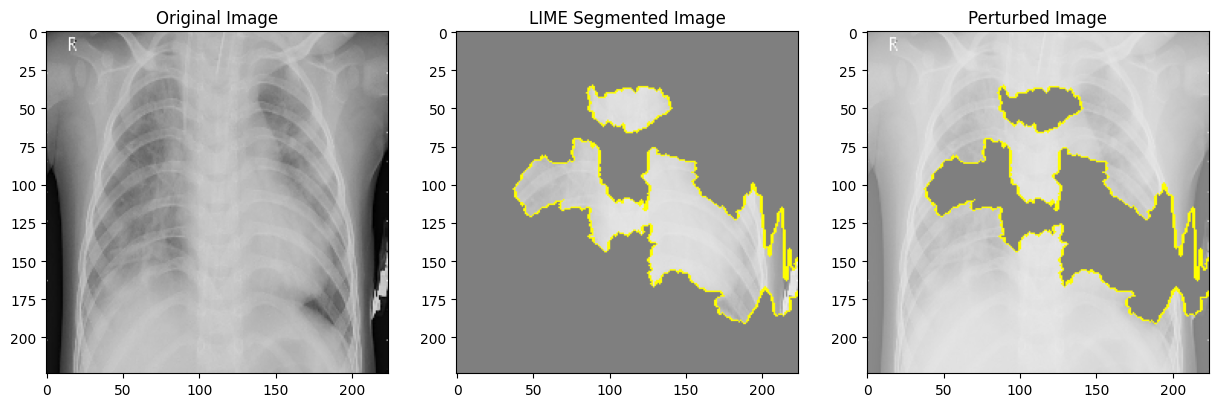

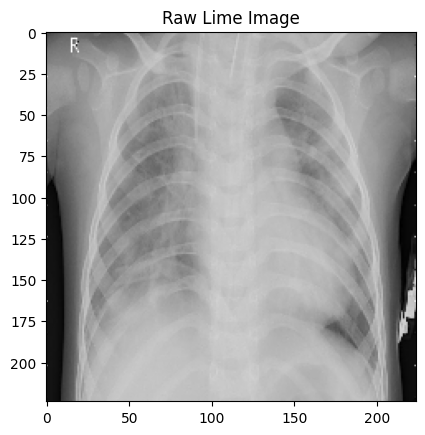

Superpixel Positions:
[[ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 ...
 [24 24 24 ... 28 28 28]
 [24 24 24 ... 28 28 28]
 [24 24 24 ... 28 28 28]]


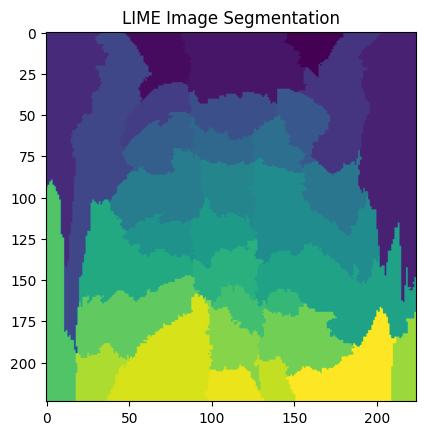

In [25]:
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

def perturb_image(img, mask):
    # Create a perturbed version of the image based on the LIME mask
    perturbed_img = img.copy()
    perturbed_img[mask == 1] = 0  # Set the superpixels in the mask to 0

    return perturbed_img

def display_side_by_side(images, titles):
    # Display multiple images side by side
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])

    plt.show()

def explain_prediction_lime(model, img_path, class_index=0, num_samples=1000):
    # Load and preprocess the image
    img = load_and_preprocess_image(img_path)

    # Define the LIME explainer for image classification
    explainer = lime_image.LimeImageExplainer()

    # Explain the prediction
    explanation = explainer.explain_instance(img[0], model.predict, top_labels=1, hide_color=0, num_samples=num_samples)

    # Get LIME segmented image
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    # Create a heatmap from the LIME mask
    lime_segmented_img = mark_boundaries(temp / 2 + 0.5, mask)

    # Access local feature importance values
    exp_list = explanation.local_exp[explanation.top_labels[0]]
    print("LIME Explanation as List:")
    print(exp_list)

    # Get perturbed image
    perturbed_img = perturb_image(img[0], mask)
    perturbed_segmented_img = mark_boundaries(perturbed_img / 2 + 0.5, mask)

    # Display images side by side
    images = [img[0], lime_segmented_img, perturbed_segmented_img]
    titles = ["Original Image", "LIME Segmented Image", "Perturbed Image"]
    display_side_by_side(images, titles)

    # Additional Lime functions
    raw_lime_img = explanation.image
    plt.imshow(raw_lime_img)
    plt.title("Raw Lime Image")
    plt.show()

    superpixel = explanation.segments
    print("Superpixel Positions:")
    print(superpixel)

    # Use lime_image's various functions
    lime_image_functions(explanation)

    return lime_segmented_img, explanation

def lime_image_functions(explanation):
    # Use more lime_image functions here
    # Example: 
    segmentation = explanation.segments
    plt.imshow(segmentation, cmap='viridis')
    plt.title("LIME Image Segmentation")
    plt.show()
    
# Example usage:
image_path = 'chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg'
lime_segmented_img, lime_explanation = explain_prediction_lime(model, image_path, class_index=0)


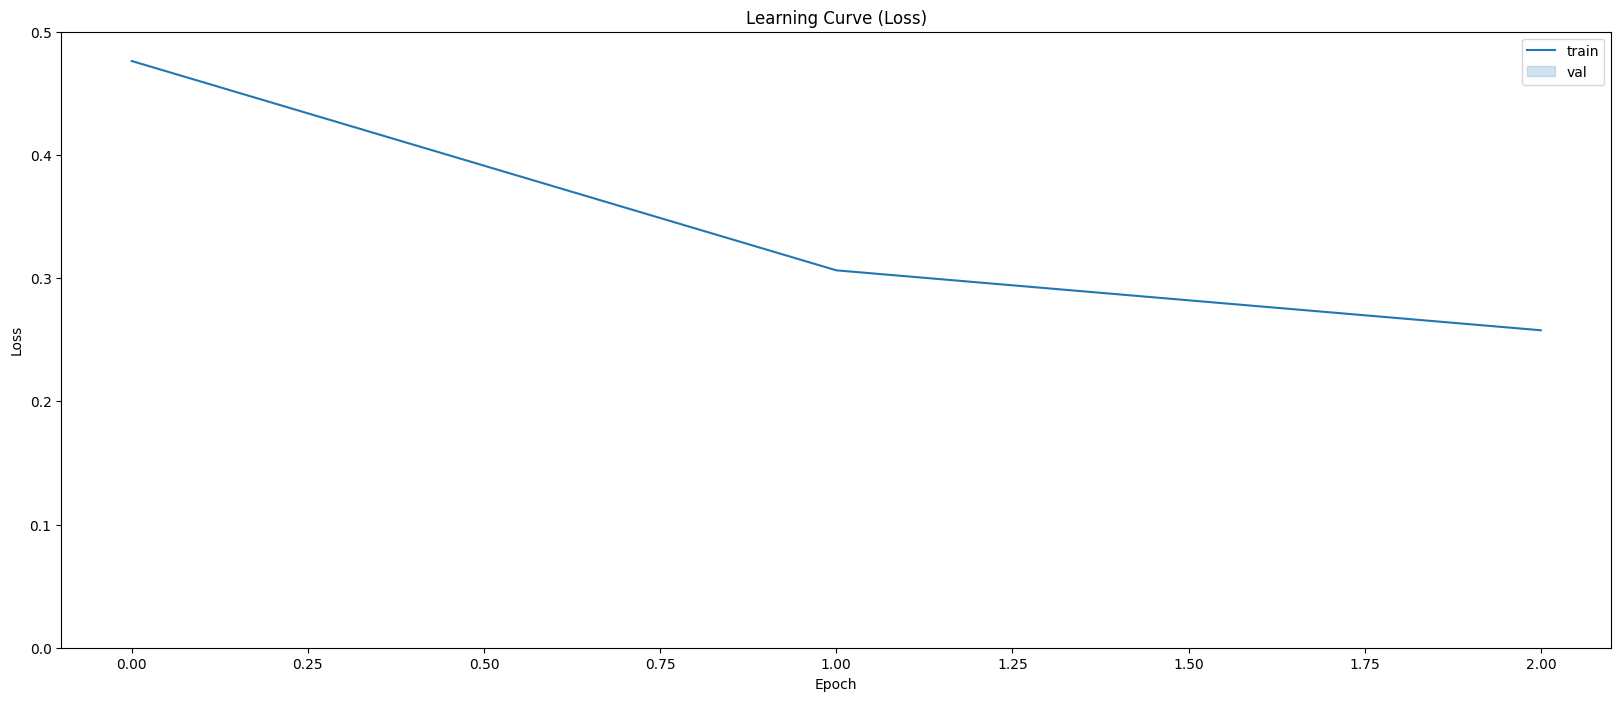

In [26]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

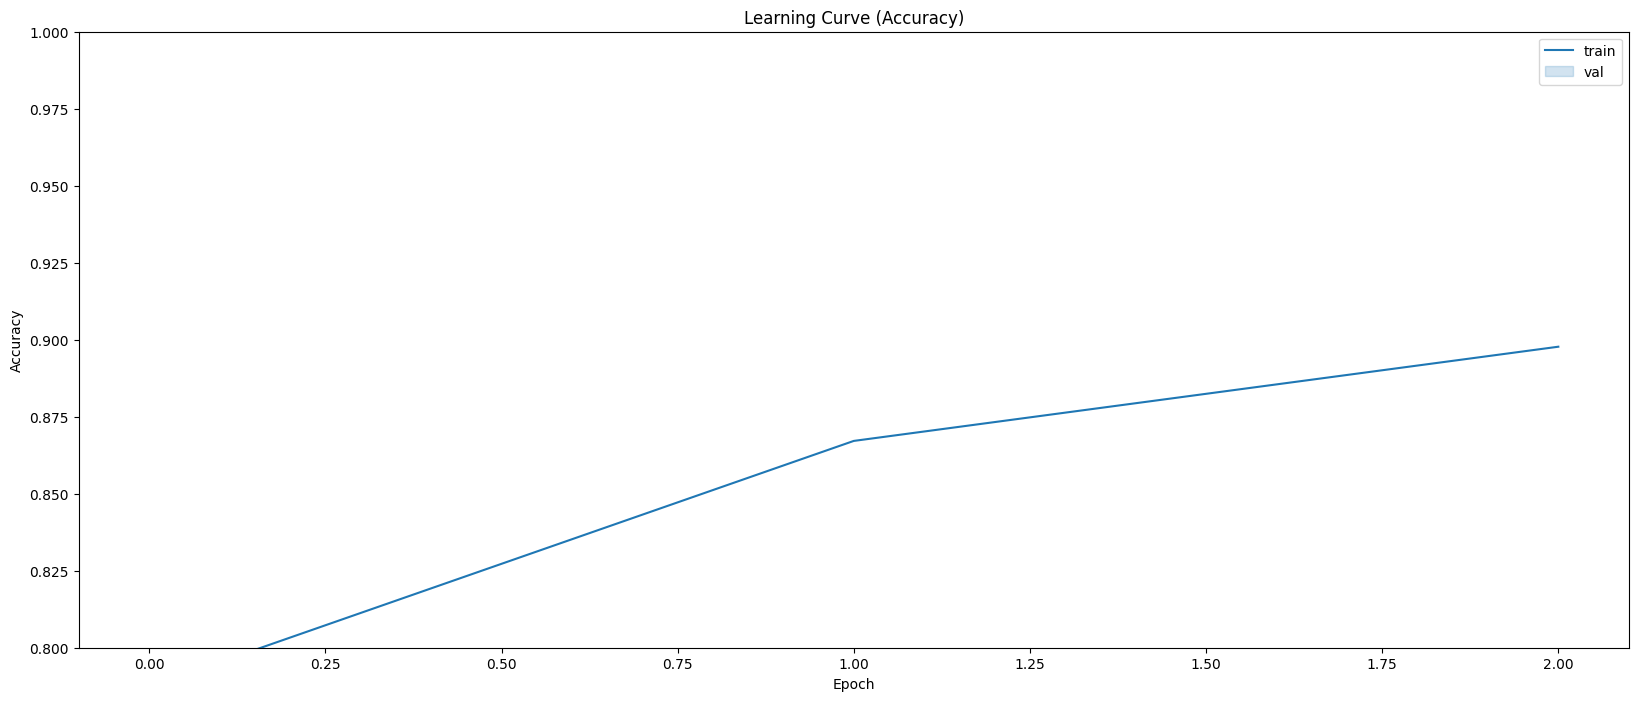

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [28]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.757261037826538
Val accuracy: 0.7421203255653381


In [29]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.7088444232940674
Test accuracy: 0.625


# <a id="6">Transfer Learning</a> 

The second approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/resnet/#resnet152v2-function). 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.



In [30]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [31]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [32]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 3,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/3
130/130 [==============================] - 427s 3s/step - loss: 0.3130 - binary_accuracy: 0.8762 - val_loss: 0.1914 - val_binary_accuracy: 0.9322 - lr: 5.0000e-05
Epoch 2/3
130/130 [==============================] - 420s 3s/step - loss: 0.1814 - binary_accuracy: 0.9324 - val_loss: 0.1521 - val_binary_accuracy: 0.9427 - lr: 5.0000e-05
Epoch 3/3
130/130 [==============================] - 414s 3s/step - loss: 0.1571 - binary_accuracy: 0.9422 - val_loss: 0.1391 - val_binary_accuracy: 0.9503 - lr: 5.0000e-05


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  1%|▊                                                                               | 10/1000 [00:03<06:13,  2.65it/s]

1/1 [==============================] - 1s 750ms/step


  2%|█▌                                                                              | 20/1000 [00:04<03:20,  4.89it/s]

1/1 [==============================] - 1s 748ms/step


  3%|██▍                                                                             | 30/1000 [00:05<02:24,  6.70it/s]

1/1 [==============================] - 1s 751ms/step


  4%|███▏                                                                            | 40/1000 [00:06<01:58,  8.12it/s]

1/1 [==============================] - 1s 744ms/step


  5%|████                                                                            | 50/1000 [00:07<01:43,  9.21it/s]

1/1 [==============================] - 1s 751ms/step


  6%|████▊                                                                           | 60/1000 [00:07<01:33, 10.02it/s]

1/1 [==============================] - 1s 751ms/step


  7%|█████▌                                                                          | 70/1000 [00:08<01:27, 10.60it/s]

1/1 [==============================] - 1s 762ms/step


  8%|██████▍                                                                         | 80/1000 [00:09<01:23, 10.98it/s]

1/1 [==============================] - 1s 753ms/step


  9%|███████▏                                                                        | 90/1000 [00:10<01:20, 11.27it/s]

1/1 [==============================] - 1s 756ms/step


 10%|███████▉                                                                       | 100/1000 [00:11<01:18, 11.46it/s]

1/1 [==============================] - 1s 751ms/step


 11%|████████▋                                                                      | 110/1000 [00:12<01:16, 11.63it/s]

1/1 [==============================] - 1s 741ms/step


 12%|█████████▍                                                                     | 120/1000 [00:12<01:14, 11.77it/s]

1/1 [==============================] - 1s 754ms/step


 13%|██████████▎                                                                    | 130/1000 [00:13<01:13, 11.84it/s]

1/1 [==============================] - 1s 785ms/step


 14%|███████████                                                                    | 140/1000 [00:14<01:13, 11.75it/s]

1/1 [==============================] - 1s 746ms/step


 15%|███████████▊                                                                   | 150/1000 [00:15<01:11, 11.81it/s]

1/1 [==============================] - 1s 742ms/step


 16%|████████████▋                                                                  | 160/1000 [00:16<01:10, 11.90it/s]

1/1 [==============================] - 1s 747ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:17<01:09, 11.88it/s]

1/1 [==============================] - 1s 747ms/step


 18%|██████████████▏                                                                | 180/1000 [00:17<01:08, 11.92it/s]

1/1 [==============================] - 1s 742ms/step


 19%|███████████████                                                                | 190/1000 [00:18<01:07, 11.98it/s]

1/1 [==============================] - 1s 744ms/step


 20%|███████████████▊                                                               | 200/1000 [00:19<01:06, 12.02it/s]

1/1 [==============================] - 1s 749ms/step


 21%|████████████████▌                                                              | 210/1000 [00:20<01:05, 12.00it/s]

1/1 [==============================] - 1s 742ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:21<01:04, 12.06it/s]

1/1 [==============================] - 1s 755ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:22<01:04, 12.03it/s]

1/1 [==============================] - 1s 747ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:22<01:03, 12.04it/s]

1/1 [==============================] - 1s 748ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:23<01:02, 12.06it/s]

1/1 [==============================] - 1s 744ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:24<01:01, 12.10it/s]

1/1 [==============================] - 1s 746ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:25<01:00, 12.09it/s]

1/1 [==============================] - 1s 749ms/step


 28%|██████████████████████                                                         | 280/1000 [00:26<00:59, 12.01it/s]

1/1 [==============================] - 1s 744ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:27<00:58, 12.05it/s]

1/1 [==============================] - 1s 746ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:27<00:58, 12.04it/s]

1/1 [==============================] - 1s 744ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:28<00:57, 12.05it/s]

1/1 [==============================] - 1s 747ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:29<00:56, 12.06it/s]

1/1 [==============================] - 1s 750ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:30<00:55, 12.04it/s]

1/1 [==============================] - 1s 750ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:31<00:54, 12.03it/s]

1/1 [==============================] - 1s 749ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:32<00:54, 12.02it/s]

1/1 [==============================] - 1s 748ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:32<00:53, 12.02it/s]

1/1 [==============================] - 1s 753ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:33<00:52, 12.01it/s]

1/1 [==============================] - 1s 754ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:34<00:51, 11.98it/s]

1/1 [==============================] - 1s 746ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:35<00:50, 11.99it/s]

1/1 [==============================] - 1s 744ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:36<00:50, 11.99it/s]

1/1 [==============================] - 1s 747ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:37<00:49, 12.00it/s]

1/1 [==============================] - 1s 753ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:37<00:48, 11.99it/s]

1/1 [==============================] - 1s 747ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:38<00:47, 12.01it/s]

1/1 [==============================] - 1s 744ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:39<00:46, 12.01it/s]

1/1 [==============================] - 1s 754ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:40<00:45, 11.98it/s]

1/1 [==============================] - 1s 741ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:41<00:44, 12.04it/s]

1/1 [==============================] - 1s 751ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:42<00:44, 12.04it/s]

1/1 [==============================] - 1s 738ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:42<00:43, 12.05it/s]

1/1 [==============================] - 1s 750ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:43<00:42, 12.04it/s]

1/1 [==============================] - 1s 749ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:44<00:41, 12.01it/s]

1/1 [==============================] - 1s 744ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:45<00:40, 12.00it/s]

1/1 [==============================] - 1s 754ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:46<00:40, 11.99it/s]

1/1 [==============================] - 1s 740ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:47<00:39, 12.04it/s]

1/1 [==============================] - 1s 759ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:47<00:38, 11.99it/s]

1/1 [==============================] - 1s 749ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:48<00:37, 12.00it/s]

1/1 [==============================] - 1s 744ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:49<00:36, 12.03it/s]

1/1 [==============================] - 1s 749ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:50<00:35, 12.04it/s]

1/1 [==============================] - 1s 741ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:51<00:34, 12.06it/s]

1/1 [==============================] - 1s 749ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:52<00:34, 12.06it/s]

1/1 [==============================] - 1s 750ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:52<00:33, 12.05it/s]

1/1 [==============================] - 1s 745ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:53<00:32, 12.06it/s]

1/1 [==============================] - 1s 747ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:54<00:31, 12.06it/s]

1/1 [==============================] - 1s 745ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:55<00:30, 12.02it/s]

1/1 [==============================] - 1s 745ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:56<00:29, 12.04it/s]

1/1 [==============================] - 1s 749ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:57<00:29, 12.04it/s]

1/1 [==============================] - 1s 751ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:57<00:28, 12.03it/s]

1/1 [==============================] - 1s 749ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:58<00:27, 12.04it/s]

1/1 [==============================] - 1s 749ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:59<00:26, 12.03it/s]

1/1 [==============================] - 1s 742ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [01:00<00:25, 12.06it/s]

1/1 [==============================] - 1s 751ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [01:01<00:24, 12.03it/s]

1/1 [==============================] - 1s 745ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [01:02<00:24, 12.05it/s]

1/1 [==============================] - 1s 743ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [01:02<00:23, 12.07it/s]

1/1 [==============================] - 1s 747ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [01:03<00:22, 12.07it/s]

1/1 [==============================] - 1s 755ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [01:04<00:21, 11.98it/s]

1/1 [==============================] - 1s 751ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [01:05<00:20, 12.01it/s]

1/1 [==============================] - 1s 742ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [01:06<00:19, 12.04it/s]

1/1 [==============================] - 1s 746ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [01:06<00:19, 12.04it/s]

1/1 [==============================] - 1s 744ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [01:07<00:18, 12.04it/s]

1/1 [==============================] - 1s 747ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [01:08<00:17, 12.04it/s]

1/1 [==============================] - 1s 748ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [01:09<00:16, 12.04it/s]

1/1 [==============================] - 1s 757ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [01:10<00:15, 11.99it/s]

1/1 [==============================] - 1s 742ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:11<00:14, 12.03it/s]

1/1 [==============================] - 1s 744ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [01:11<00:14, 12.04it/s]

1/1 [==============================] - 1s 743ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [01:12<00:13, 12.06it/s]

1/1 [==============================] - 1s 751ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [01:13<00:12, 12.05it/s]

1/1 [==============================] - 1s 751ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [01:14<00:11, 12.00it/s]

1/1 [==============================] - 1s 746ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [01:15<00:10, 12.02it/s]

1/1 [==============================] - 1s 740ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [01:16<00:09, 12.08it/s]

1/1 [==============================] - 1s 741ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [01:16<00:09, 12.10it/s]

1/1 [==============================] - 1s 757ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [01:17<00:08, 12.05it/s]

1/1 [==============================] - 1s 744ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [01:18<00:07, 12.07it/s]

1/1 [==============================] - 1s 742ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [01:19<00:06, 12.09it/s]

1/1 [==============================] - 1s 744ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [01:20<00:05, 12.11it/s]

1/1 [==============================] - 1s 747ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [01:21<00:04, 12.09it/s]

1/1 [==============================] - 1s 745ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [01:21<00:04, 12.09it/s]

1/1 [==============================] - 1s 740ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [01:22<00:03, 12.12it/s]

1/1 [==============================] - 1s 740ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [01:23<00:02, 12.12it/s]

1/1 [==============================] - 1s 745ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [01:24<00:01, 12.07it/s]

1/1 [==============================] - 1s 744ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [01:25<00:00, 12.07it/s]

1/1 [==============================] - 1s 741ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.62it/s]

LIME Explanation as List:
[(19, 0.050867878824335105), (24, 0.04290471795027778), (16, 0.04184719927444724), (7, 0.03650874165795632), (4, 0.029769241067787604), (20, 0.02949079941067019), (21, 0.0238034396113528), (3, -0.021969069918788678), (26, 0.019957173960189672), (25, 0.019033881029900064), (17, 0.018388677845862247), (15, 0.01835361946449718), (13, 0.018286535711878316), (14, 0.01790556900177978), (2, 0.016432204258315725), (5, 0.01631776877022005), (18, 0.015551352891275417), (6, 0.012778178826023782), (8, 0.012039180544303805), (33, -0.011191689326054648), (30, 0.008991003670590894), (11, 0.008191003835267741), (22, -0.006244728932664527), (27, 0.006219292235442827), (32, 0.006008775410791385), (31, -0.005938920403182765), (10, 0.005234121369355524), (28, -0.004983595196376095), (9, 0.0034891178388747907), (12, 0.002841086459790601), (1, 0.0016000453690000842), (29, 0.000927890243914323), (23, -0.0008274207711073593), (0, -0.00046008141220477025)]


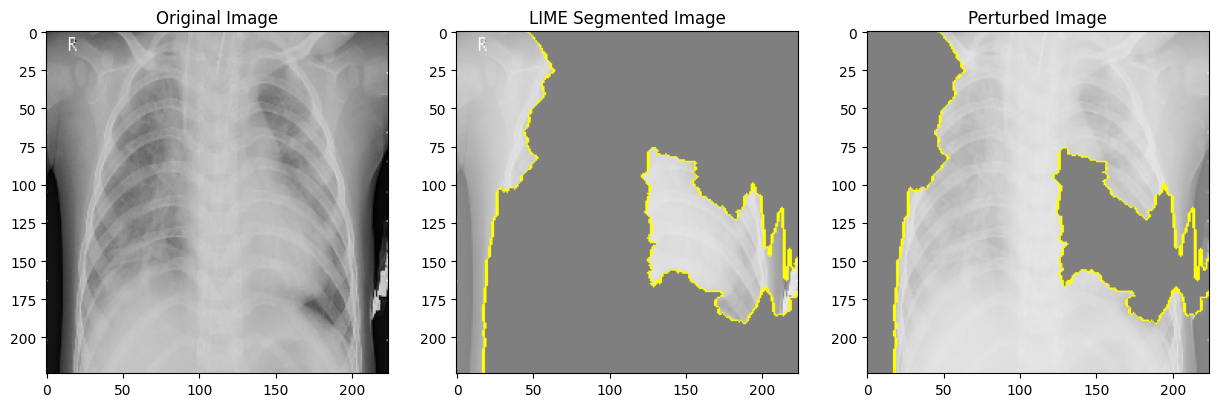

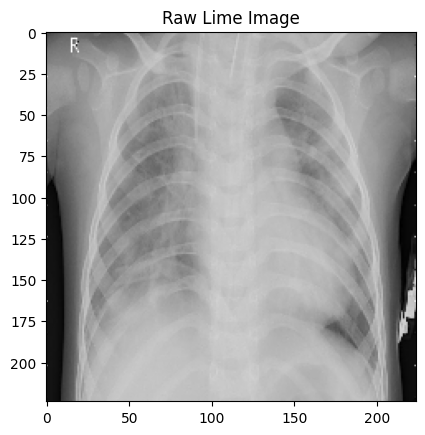

Superpixel Positions:
[[ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 ...
 [24 24 24 ... 28 28 28]
 [24 24 24 ... 28 28 28]
 [24 24 24 ... 28 28 28]]


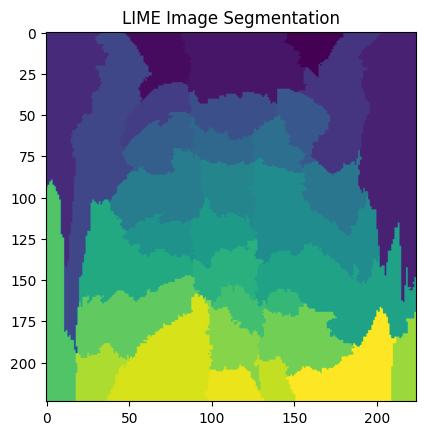

In [33]:
image_path = 'chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg'
lime_segmented_img, lime_explanation = explain_prediction_lime(model_pretrained, image_path, class_index=0)


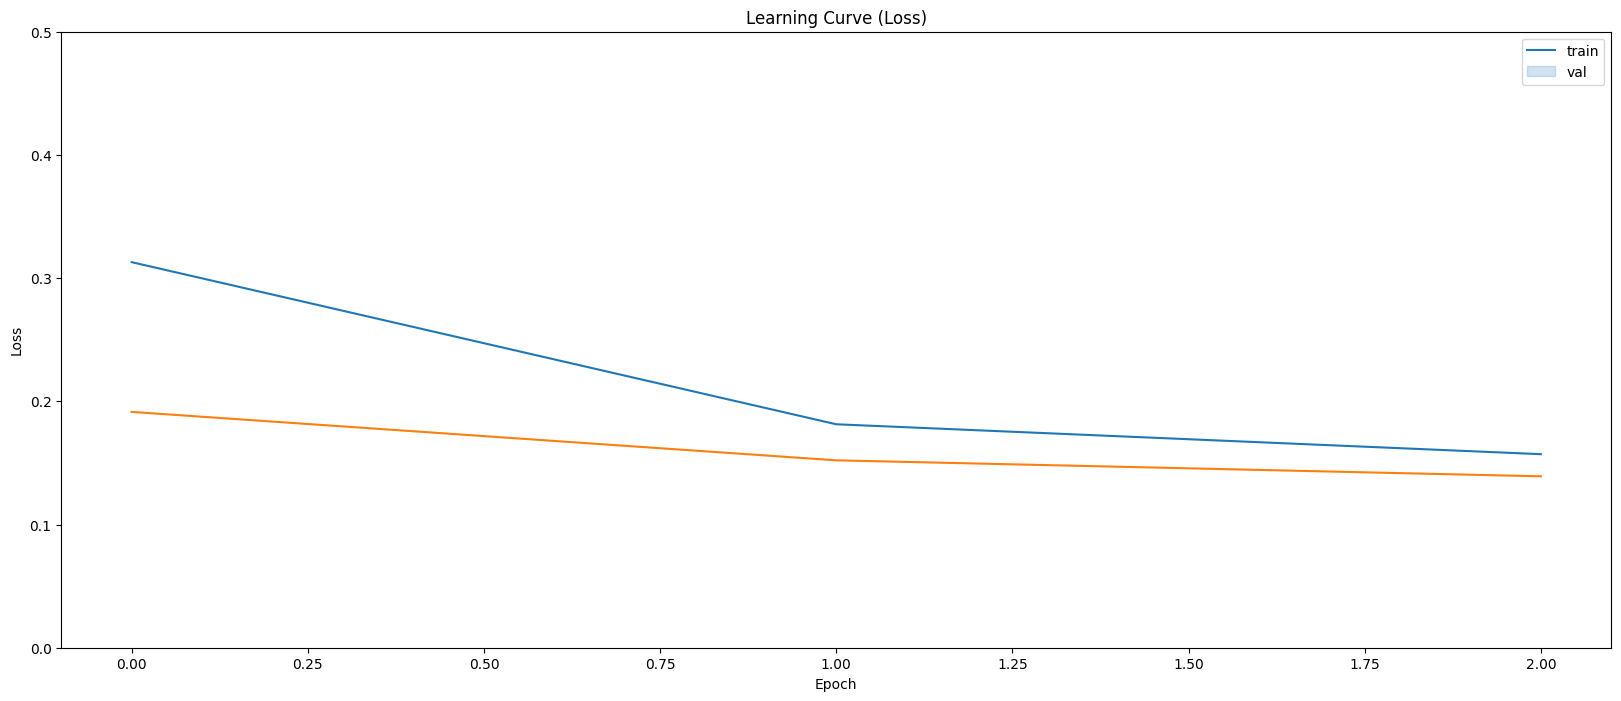

In [34]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

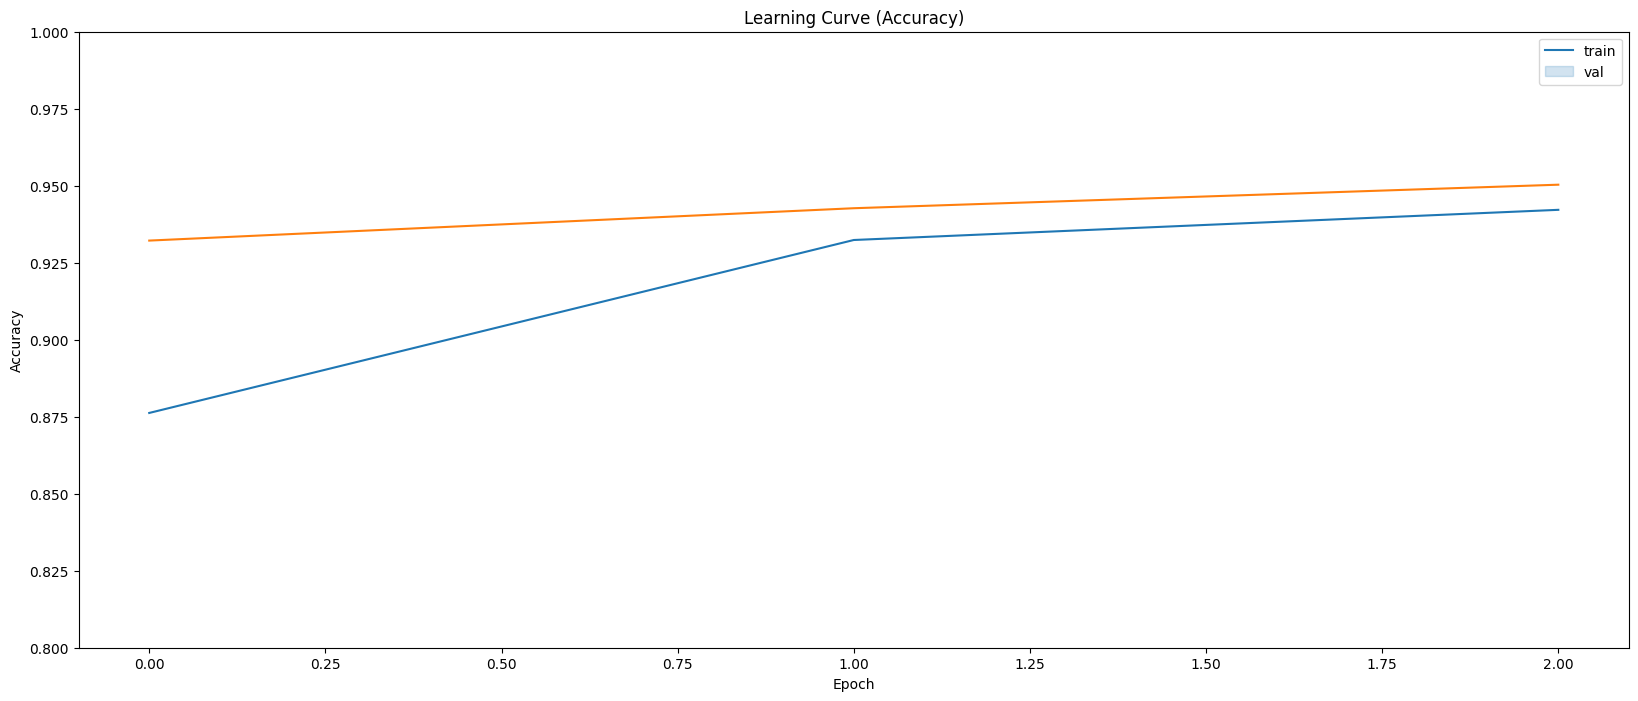

In [35]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [36]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.13912606239318848
Val accuracy: 0.9503343105316162


In [37]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.30679914355278015
Test accuracy: 0.8637820482254028


# <a id="7">Fine Tuning</a> 

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [38]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [39]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [40]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [41]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 3,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/3
130/130 [==============================] - 443s 3s/step - loss: 0.1350 - binary_accuracy: 0.9524 - val_loss: 0.1464 - val_binary_accuracy: 0.9685 - lr: 0.0010
Epoch 2/3
130/130 [==============================] - 435s 3s/step - loss: 0.0807 - binary_accuracy: 0.9747 - val_loss: 0.1497 - val_binary_accuracy: 0.9675 - lr: 0.0010
Epoch 3/3
130/130 [==============================] - 449s 3s/step - loss: 0.0880 - binary_accuracy: 0.9732 - val_loss: 0.1072 - val_binary_accuracy: 0.9599 - lr: 0.0010


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  1%|▊                                                                               | 10/1000 [00:03<05:53,  2.80it/s]

1/1 [==============================] - 1s 748ms/step


  2%|█▌                                                                              | 20/1000 [00:04<03:11,  5.11it/s]

1/1 [==============================] - 1s 736ms/step


  3%|██▍                                                                             | 30/1000 [00:05<02:19,  6.96it/s]

1/1 [==============================] - 1s 737ms/step


  4%|███▏                                                                            | 40/1000 [00:06<01:54,  8.37it/s]

1/1 [==============================] - 1s 741ms/step


  5%|████                                                                            | 50/1000 [00:06<01:40,  9.41it/s]

1/1 [==============================] - 1s 741ms/step


  6%|████▊                                                                           | 60/1000 [00:07<01:32, 10.18it/s]

1/1 [==============================] - 1s 737ms/step


  7%|█████▌                                                                          | 70/1000 [00:08<01:26, 10.75it/s]

1/1 [==============================] - 1s 740ms/step


  8%|██████▍                                                                         | 80/1000 [00:09<01:22, 11.16it/s]

1/1 [==============================] - 1s 737ms/step


  9%|███████▏                                                                        | 90/1000 [00:10<01:19, 11.46it/s]

1/1 [==============================] - 1s 743ms/step


 10%|███████▉                                                                       | 100/1000 [00:10<01:17, 11.65it/s]

1/1 [==============================] - 1s 734ms/step


 11%|████████▋                                                                      | 110/1000 [00:11<01:15, 11.81it/s]

1/1 [==============================] - 1s 738ms/step


 12%|█████████▍                                                                     | 120/1000 [00:12<01:13, 11.92it/s]

1/1 [==============================] - 1s 738ms/step


 13%|██████████▎                                                                    | 130/1000 [00:13<01:12, 12.01it/s]

1/1 [==============================] - 1s 736ms/step


 14%|███████████                                                                    | 140/1000 [00:14<01:11, 12.06it/s]

1/1 [==============================] - 1s 740ms/step


 15%|███████████▊                                                                   | 150/1000 [00:15<01:10, 12.08it/s]

1/1 [==============================] - 1s 735ms/step


 16%|████████████▋                                                                  | 160/1000 [00:15<01:09, 12.13it/s]

1/1 [==============================] - 1s 731ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:16<01:08, 12.11it/s]

1/1 [==============================] - 1s 739ms/step


 18%|██████████████▏                                                                | 180/1000 [00:17<01:07, 12.14it/s]

1/1 [==============================] - 1s 730ms/step


 19%|███████████████                                                                | 190/1000 [00:18<01:06, 12.21it/s]

1/1 [==============================] - 1s 741ms/step


 20%|███████████████▊                                                               | 200/1000 [00:19<01:05, 12.17it/s]

1/1 [==============================] - 1s 746ms/step


 21%|████████████████▌                                                              | 210/1000 [00:20<01:05, 12.13it/s]

1/1 [==============================] - 1s 735ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:20<01:04, 12.17it/s]

1/1 [==============================] - 1s 752ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:21<01:03, 12.11it/s]

1/1 [==============================] - 1s 743ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:22<01:02, 12.10it/s]

1/1 [==============================] - 1s 741ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:23<01:01, 12.10it/s]

1/1 [==============================] - 1s 731ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:24<01:00, 12.15it/s]

1/1 [==============================] - 1s 744ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:24<01:00, 12.14it/s]

1/1 [==============================] - 1s 725ms/step


 28%|██████████████████████                                                         | 280/1000 [00:25<00:58, 12.23it/s]

1/1 [==============================] - 1s 733ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:26<00:58, 12.19it/s]

1/1 [==============================] - 1s 741ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:27<00:57, 12.18it/s]

1/1 [==============================] - 1s 742ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:28<00:56, 12.17it/s]

1/1 [==============================] - 1s 737ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:29<00:55, 12.19it/s]

1/1 [==============================] - 1s 732ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:29<00:54, 12.20it/s]

1/1 [==============================] - 1s 733ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:30<00:53, 12.24it/s]

1/1 [==============================] - 1s 733ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:31<00:53, 12.24it/s]

1/1 [==============================] - 1s 729ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:32<00:52, 12.26it/s]

1/1 [==============================] - 1s 737ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:33<00:51, 12.24it/s]

1/1 [==============================] - 1s 727ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:33<00:50, 12.27it/s]

1/1 [==============================] - 1s 738ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:34<00:49, 12.26it/s]

1/1 [==============================] - 1s 733ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:35<00:49, 12.21it/s]

1/1 [==============================] - 1s 739ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:36<00:48, 12.19it/s]

1/1 [==============================] - 1s 738ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:37<00:47, 12.21it/s]

1/1 [==============================] - 1s 744ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:38<00:46, 12.19it/s]

1/1 [==============================] - 1s 740ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:38<00:45, 12.19it/s]

1/1 [==============================] - 1s 741ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:39<00:45, 12.18it/s]

1/1 [==============================] - 1s 737ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:40<00:44, 12.19it/s]

1/1 [==============================] - 1s 748ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:41<00:43, 12.15it/s]

1/1 [==============================] - 1s 740ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:42<00:42, 12.15it/s]

1/1 [==============================] - 1s 748ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:43<00:42, 12.10it/s]

1/1 [==============================] - 1s 746ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:43<00:41, 12.09it/s]

1/1 [==============================] - 1s 735ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:44<00:40, 12.14it/s]

1/1 [==============================] - 1s 735ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:45<00:39, 12.13it/s]

1/1 [==============================] - 1s 743ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:46<00:38, 12.14it/s]

1/1 [==============================] - 1s 748ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:47<00:37, 12.11it/s]

1/1 [==============================] - 1s 742ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:47<00:37, 12.11it/s]

1/1 [==============================] - 1s 749ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:48<00:36, 12.09it/s]

1/1 [==============================] - 1s 738ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:49<00:35, 12.11it/s]

1/1 [==============================] - 1s 734ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:50<00:34, 12.16it/s]

1/1 [==============================] - 1s 731ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:51<00:33, 12.22it/s]

1/1 [==============================] - 1s 746ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:52<00:32, 12.18it/s]

1/1 [==============================] - 1s 744ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:52<00:32, 12.17it/s]

1/1 [==============================] - 1s 742ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:53<00:31, 12.16it/s]

1/1 [==============================] - 1s 735ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:54<00:30, 12.14it/s]

1/1 [==============================] - 1s 756ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:55<00:29, 12.09it/s]

1/1 [==============================] - 1s 758ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:56<00:29, 12.03it/s]

1/1 [==============================] - 1s 742ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:57<00:28, 12.07it/s]

1/1 [==============================] - 1s 740ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:57<00:27, 12.08it/s]

1/1 [==============================] - 1s 737ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:58<00:26, 12.11it/s]

1/1 [==============================] - 1s 735ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:59<00:25, 12.14it/s]

1/1 [==============================] - 1s 737ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [01:00<00:24, 12.18it/s]

1/1 [==============================] - 1s 736ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [01:01<00:23, 12.20it/s]

1/1 [==============================] - 1s 737ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [01:01<00:22, 12.21it/s]

1/1 [==============================] - 1s 737ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [01:02<00:22, 12.19it/s]

1/1 [==============================] - 1s 746ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [01:03<00:21, 12.16it/s]

1/1 [==============================] - 1s 749ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [01:04<00:20, 12.08it/s]

1/1 [==============================] - 1s 746ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [01:05<00:19, 12.07it/s]

1/1 [==============================] - 1s 746ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [01:06<00:19, 12.08it/s]

1/1 [==============================] - 1s 743ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [01:06<00:18, 12.09it/s]

1/1 [==============================] - 1s 742ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [01:07<00:17, 12.10it/s]

1/1 [==============================] - 1s 746ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [01:08<00:16, 12.10it/s]

1/1 [==============================] - 1s 750ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [01:09<00:15, 12.07it/s]

1/1 [==============================] - 1s 753ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:10<00:14, 12.04it/s]

1/1 [==============================] - 1s 754ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [01:11<00:14, 12.01it/s]

1/1 [==============================] - 1s 748ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [01:11<00:13, 12.02it/s]

1/1 [==============================] - 1s 750ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [01:12<00:12, 12.01it/s]

1/1 [==============================] - 1s 743ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [01:13<00:11, 11.99it/s]

1/1 [==============================] - 1s 753ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [01:14<00:10, 12.00it/s]

1/1 [==============================] - 1s 742ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [01:15<00:09, 12.04it/s]

1/1 [==============================] - 1s 735ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [01:16<00:09, 12.09it/s]

1/1 [==============================] - 1s 742ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [01:16<00:08, 12.09it/s]

1/1 [==============================] - 1s 737ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [01:17<00:07, 12.12it/s]

1/1 [==============================] - 1s 733ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [01:18<00:06, 12.15it/s]

1/1 [==============================] - 1s 735ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [01:19<00:05, 12.09it/s]

1/1 [==============================] - 1s 740ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [01:20<00:04, 12.11it/s]

1/1 [==============================] - 1s 738ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [01:21<00:04, 12.12it/s]

1/1 [==============================] - 1s 734ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [01:21<00:03, 12.16it/s]

1/1 [==============================] - 1s 739ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [01:22<00:02, 12.17it/s]

1/1 [==============================] - 1s 734ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [01:23<00:01, 12.15it/s]

1/1 [==============================] - 1s 744ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [01:24<00:00, 12.13it/s]

1/1 [==============================] - 1s 741ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.75it/s]

LIME Explanation as List:
[(7, 0.07740441923015236), (2, 0.06900862207586887), (5, 0.054760150426469166), (3, 0.05211530677932259), (16, 0.05196613847242972), (14, 0.04706447240345278), (28, 0.04634431957288012), (18, 0.043684836572406946), (17, 0.04150262344540358), (21, 0.03883585040258471), (13, -0.038799298592906546), (33, 0.0385184352624907), (27, 0.03802482045378873), (10, -0.0370288598954805), (31, 0.03404176491420624), (23, -0.02941455103877681), (0, 0.02865497586296806), (19, 0.026218558909868652), (20, 0.024736211035450224), (15, 0.024298509111462502), (11, 0.023413480590552673), (22, 0.019333765440310412), (1, 0.0188587242686572), (26, 0.018395077485110666), (25, -0.014136700328319258), (9, 0.013898355206480518), (12, 0.011147921460214082), (32, 0.010290240289162401), (24, 0.008540915278480074), (30, 0.005878518390878618), (29, 0.00454023785720617), (4, 0.004089014539138938), (6, -0.0010067409734354517), (8, -6.537076911513321e-05)]


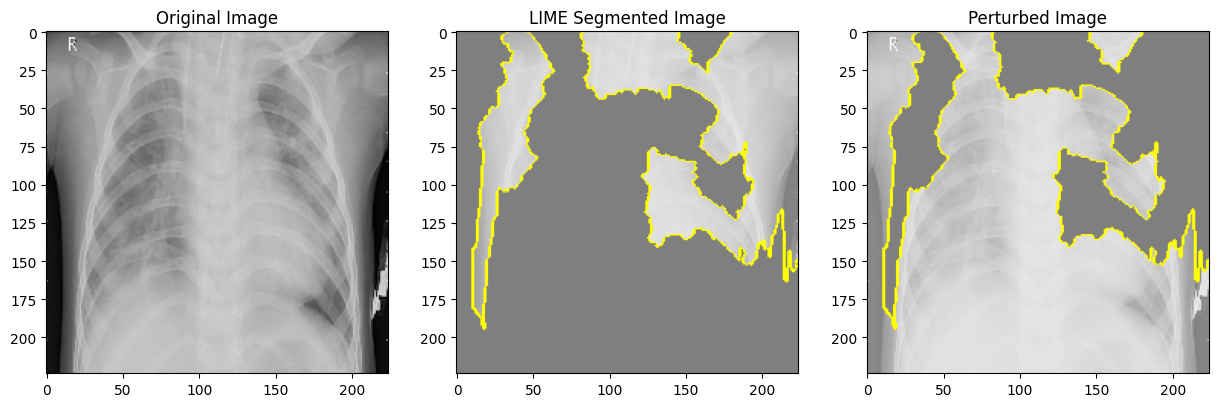

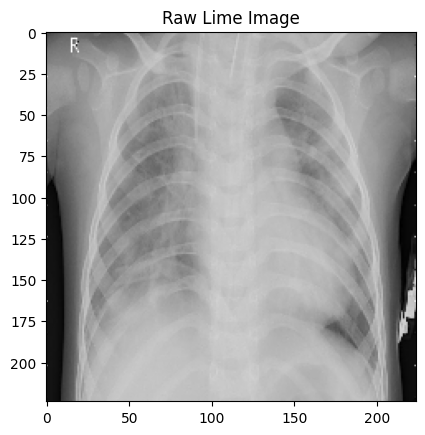

Superpixel Positions:
[[ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 ...
 [24 24 24 ... 28 28 28]
 [24 24 24 ... 28 28 28]
 [24 24 24 ... 28 28 28]]


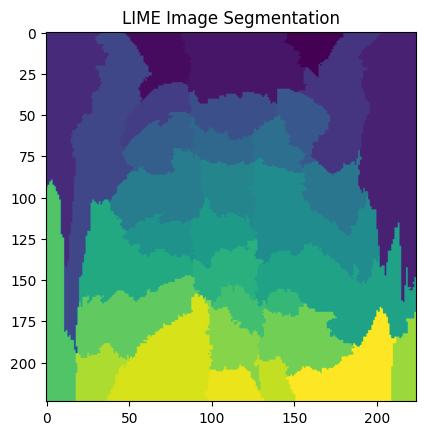

In [42]:
image_path = 'chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg'
lime_segmented_img, lime_explanation = explain_prediction_lime(model_pretrained, image_path, class_index=0)


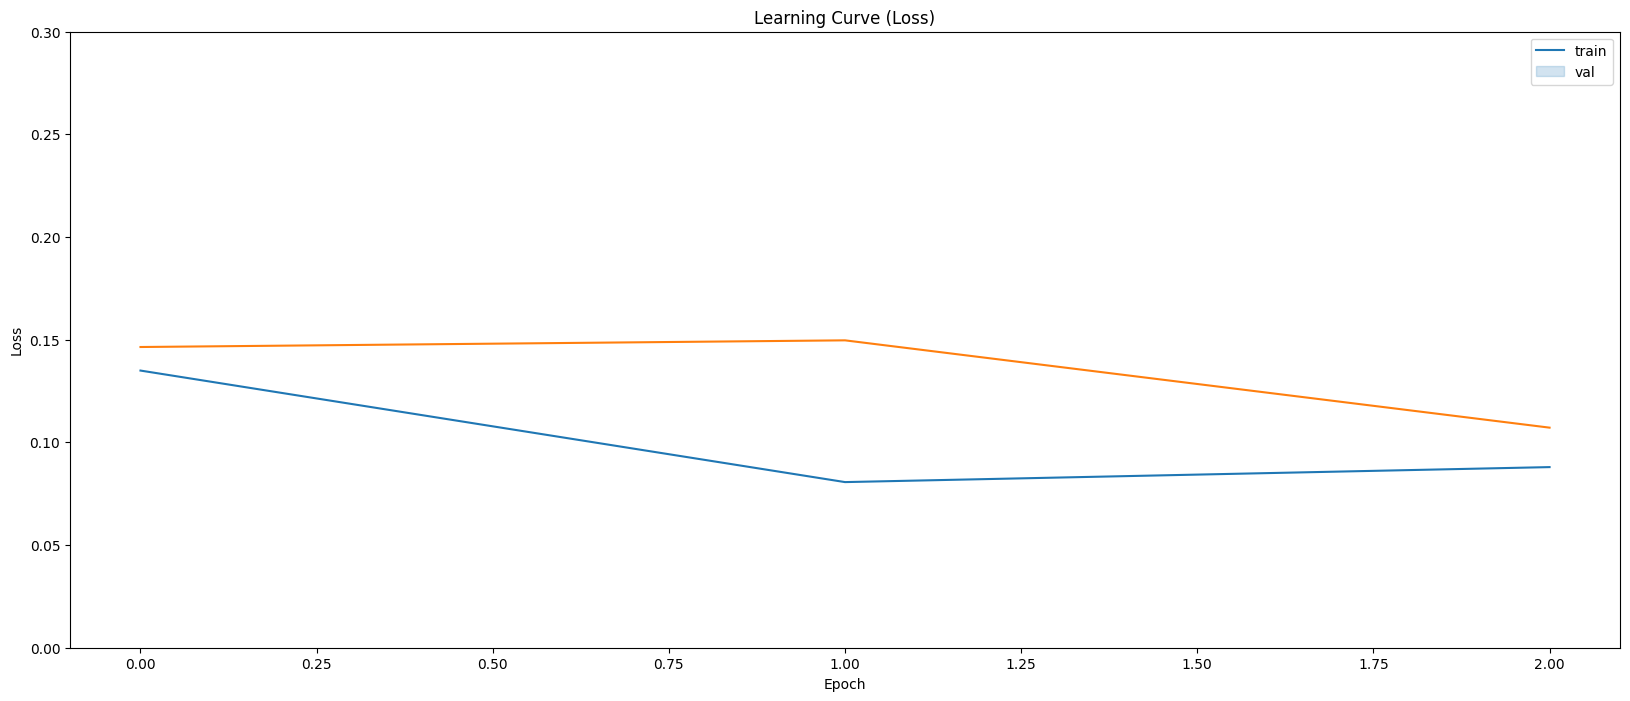

In [43]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

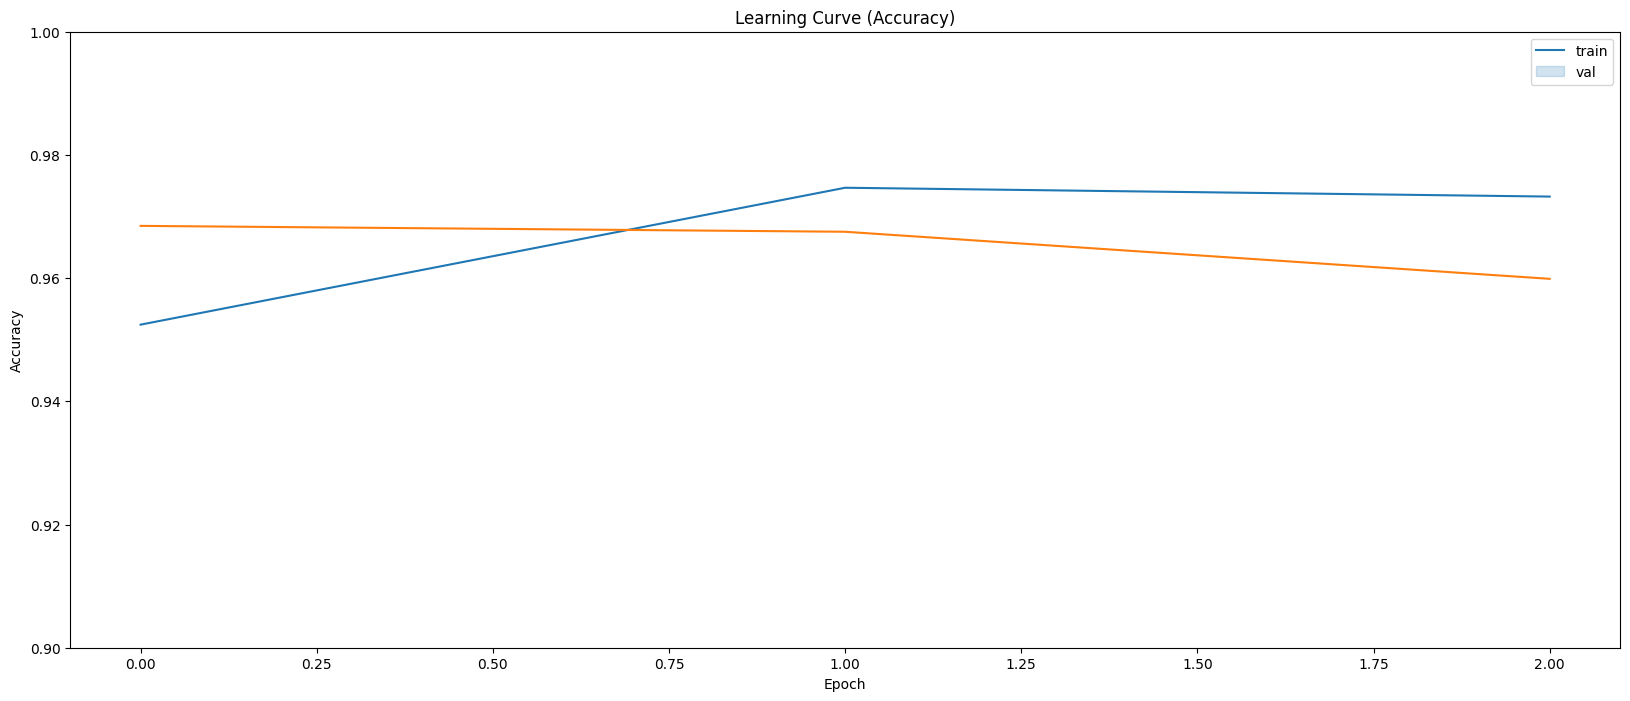

In [44]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [45]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.10717695206403732
Val accuracy: 0.9598853588104248


In [46]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1611921191215515
Test accuracy: 0.9551281929016113


As expected, the fine-tuning approach has reached the best score. We end this notebook by showing a few performance metrics.

# <a id="8">Performance Metrics</a> 

In [47]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [48]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [49]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9551282051282052


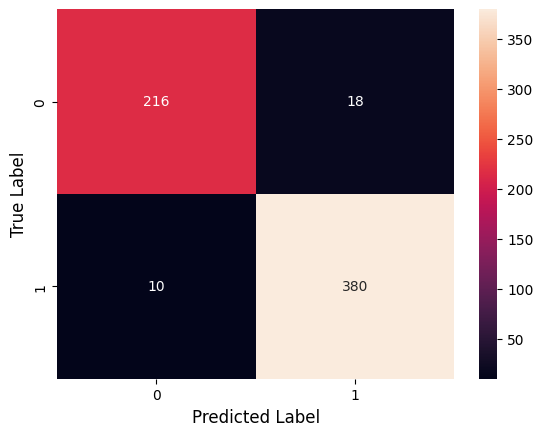

In [50]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [51]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       234
           1       0.95      0.97      0.96       390

    accuracy                           0.96       624
   macro avg       0.96      0.95      0.95       624
weighted avg       0.96      0.96      0.95       624



ROC_AUC:  0.9865548980933597


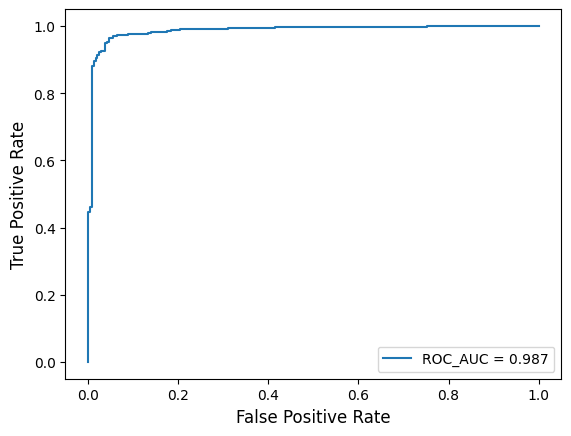

In [52]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

- https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb
- https://www.tensorflow.org/guide/keras/transfer_learning
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://keras.io/api/applications/
- https://keras.io/api/applications/resnet/#resnet152v2-function